#### Base Settings

In [348]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


##### Library

In [349]:
# Library import

## pandas
import pandas as pd

import gdown
import zipfile as zf
from tqdm import tqdm
import nltk

import os
import numpy as np
import matplotlib.pyplot as plt
import re
import json
import string
from collections import Counter
import random

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA

import tensorflow as tf
import tensorflow as keras
from keras import layers, Input, Sequential, Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Flatten, GlobalAveragePooling1D, \
                                    TextVectorization


import tensorflow_datasets as tfds

from transformers import ElectraTokenizer
from transformers import TFElectraModel

##### Parmas

In [350]:
# 각종 파라미터 지정
RAND_SEED = 83
random.seed(RAND_SEED)

NUM_TEXT_DATA      = 5000       #📌 훈련 데이터 개수
MAX_LENGTH          = 20         #📌 문장 길이
BATCH_SIZE          = 64
BUFFER_SIZE         = 20000

# Hyper-parameters
NUM_LAYERS = 3
D_MODEL = 256
EMBED_DIM = 128
NUM_HEADS = 8
DFF = 512
DROPOUT = 0.1

###### Google Drive

In [351]:
# # Google drive mout
# from google.colab import drive
# drive.mount('/content/drive')

### Data Gathering

In [352]:
def collect_json_file(path):
    """
    폴더의 json파일을 모두 불러와 리스트로 반환하는 함수
    """
    file_list = os.listdir(path)

    json_list = []
    for file_name in file_list:
        if '.json' in file_name:
            json_list.append(file_name)

    return json_list

In [353]:
def parsing_corpus(js):
    Q1_list = [js[x]["talk"]["content"]["HS01"] for x in range(len(js))]
    Q2_list = [js[x]["talk"]["content"]["HS02"] for x in range(len(js))]
    Q3_list = [js[x]["talk"]["content"]["HS03"] for x in range(len(js))]
    A1_list = [js[x]["talk"]["content"]["SS01"] for x in range(len(js))]
    A2_list = [js[x]["talk"]["content"]["SS02"] for x in range(len(js))]
    A3_list = [js[x]["talk"]["content"]["SS03"] for x in range(len(js))]

    df_qa = pd.DataFrame({"Q1":Q1_list,"A1":A1_list,"Q2":Q2_list,"A2":A2_list,"Q3":Q3_list,"A3":A3_list})

    return df_qa

#### 챗봇 문답 페어 : songys

author: songys@github
repository: https://github.com/songys/Chatbot_data
size:
train: 11,876 examples
데이터 구조는 다음과 같습니다.

속성명	내용
text	질문
pair	답변
label	일상다반사 0, 이별(부정) 1, 사랑(긍정) 2

```python
from Korpora import Korpora
Korpora.fetch("korean_chatbot_data")
```

```python
train_data = pd.read_csv('https://raw.githubusercontent.com/songys/Chatbot_data/master/ChatbotData.csv')
```

In [354]:
# train_data = pd.read_csv('https://raw.githubusercontent.com/songys/Chatbot_data/master/ChatbotData.csv')
# print(train_data.shape)
# train_data.head()

#### 감성 대화 말뭉치

- [감성 대화 말뭉치](https://aihub.or.kr/aihubdata/data/view.do?currMenu=115&topMenu=100&aihubDataSe=realm&dataSetSn=86)



2020년/10,000문장 (음성), 27만문장 (코퍼스)

In [355]:
# 공유파일 URL
# url_list = ["https://drive.google.com/file/d/1lroyujd9fnnPVWUVnqZtIUpl_bliZpCg/view?usp=sharing",
#             "https://drive.google.com/file/d/1lwHywo0OIItRgOv-nK_M_tlxTD_HhG-c/view?usp=sharing"]

url_list = ["https://drive.google.com/file/d/1lroyujd9fnnPVWUVnqZtIUpl_bliZpCg/view?usp=sharing"]

for idx, val in enumerate(url_list):
    data_url = val
    file_name = "donwload.zip"
    unzip_path = "data/emotion/"

    # 구글드라이브에서 다운로드
    file_id = "https://drive.google.com/uc?id=" + data_url.split('/')[-2]
    gdown.download(file_id, file_name)

    # 압축풀기
    files = zf.ZipFile(file_name)
    files.extractall(unzip_path)
    files.close()

json_list = collect_json_file(unzip_path)

Downloading...
From: https://drive.google.com/uc?id=1lroyujd9fnnPVWUVnqZtIUpl_bliZpCg
To: /content/donwload.zip
100%|██████████| 8.30M/8.30M [00:00<00:00, 109MB/s]


In [356]:
with tqdm(total=len(json_list)) as pbar:
    df_concat = pd.DataFrame()
    for idx, val in enumerate(json_list):
        with open(unzip_path+json_list[0]) as f:
            js = json.loads(f.read())
            df_qa = parsing_corpus(js)
            df_concat = pd.concat([df_concat,df_qa])
        pbar.update()

100%|██████████| 1/1 [00:06<00:00,  6.00s/it]


In [357]:
# 1턴만 사용
df = df_concat[["Q1","A1"]].copy()
print(df.shape)
df.sample(8, random_state=RAND_SEED)

(51628, 2)


,Q1,A1
18720,이제 암 말기로 항암제도 듣질 않아. 너무 고통스럽게 죽을 것 같아.,암 때문에 너무 무서우시겠어요.
7696,나는 뭘 해도 안 될 것 같아.,오늘 속상한 일이 있으셨나요? 왜 그런 생각을 하셨는지 궁금해요.
24555,친구가 많이 힘든 상황에 있는데 연락이 없어져서 불안해.,친구를 걱정해주시는 따뜻한 마음씨를 가지셨네요. 지금 많이 불안하시겠어요.
28578,요즈음같이 코로나일구로 외출을 억제하다 보니 돈도 별로 필요 없는 것 같아.,그렇지요? 인터넷으로 필요하신 거 주문하시곤 하세요?
31094,딸이 아픈데 약을 제대로 챙겨 먹지 않아서 화가나서 화를 냈어.,약을 잘 챙기지 않은 딸에게 화를 내셨군요.
2281,다음 달에 결혼하게 돼서 가족들과 떨어져 살아야 해. 그동안 부모님께 효도한 게 없...,결혼으로 집을 떠나게 되었군요. 부모님께 효도하지 못한 것과 결혼을 일찍 결정한 게...
23375,아들이 학교에서 친구와 싸웠다고 연락이 와서 너무 당황스러워.,아들이 친구와 싸웠다니 당황스러우셨겠네요.
34738,딸이 왜 이렇게 못생기게 낳았냐고 화를 냈어.,따님께서 그런 이유로 화를 내셔서 정말 속상하셨겠어요.


In [358]:
qna_data = df.sample(NUM_TEXT_DATA, random_state=RAND_SEED).copy()
print(qna_data.shape)
qna_data.head(8)

(5000, 2)


,Q1,A1
18720,이제 암 말기로 항암제도 듣질 않아. 너무 고통스럽게 죽을 것 같아.,암 때문에 너무 무서우시겠어요.
7696,나는 뭘 해도 안 될 것 같아.,오늘 속상한 일이 있으셨나요? 왜 그런 생각을 하셨는지 궁금해요.
24555,친구가 많이 힘든 상황에 있는데 연락이 없어져서 불안해.,친구를 걱정해주시는 따뜻한 마음씨를 가지셨네요. 지금 많이 불안하시겠어요.
28578,요즈음같이 코로나일구로 외출을 억제하다 보니 돈도 별로 필요 없는 것 같아.,그렇지요? 인터넷으로 필요하신 거 주문하시곤 하세요?
31094,딸이 아픈데 약을 제대로 챙겨 먹지 않아서 화가나서 화를 냈어.,약을 잘 챙기지 않은 딸에게 화를 내셨군요.
2281,다음 달에 결혼하게 돼서 가족들과 떨어져 살아야 해. 그동안 부모님께 효도한 게 없...,결혼으로 집을 떠나게 되었군요. 부모님께 효도하지 못한 것과 결혼을 일찍 결정한 게...
23375,아들이 학교에서 친구와 싸웠다고 연락이 와서 너무 당황스러워.,아들이 친구와 싸웠다니 당황스러우셨겠네요.
34738,딸이 왜 이렇게 못생기게 낳았냐고 화를 냈어.,따님께서 그런 이유로 화를 내셔서 정말 속상하셨겠어요.


In [359]:
qna_data = qna_data.sample(frac=1, random_state=RAND_SEED).reset_index(drop=True)
num_val_samples = int(0.15 * len(qna_data))  # 총 데이터의 15%
num_train_samples = len(qna_data) - 2 * num_val_samples  # train, val, test 비율 = 70:15:15
train_data = qna_data[:num_train_samples]
val_data = qna_data[num_train_samples : num_train_samples + num_val_samples]
test_data = qna_data[num_train_samples + num_val_samples :]

print(f"전체 데이터셋 Pair 개수: {len(qna_data)}")
print(f"학습 데이터셋 Pair 개수: {len(train_data)}")
print(f"검증 데이터셋 Pair 개수: {len(val_data)}")
print(f"시험 데이터셋 Pair 개수: {len(test_data)}")

전체 데이터셋 Pair 개수: 5000
학습 데이터셋 Pair 개수: 3500
검증 데이터셋 Pair 개수: 750
시험 데이터셋 Pair 개수: 750


In [360]:
q_train, a_train = list(train_data["Q1"]), list(train_data["A1"])
q_val, a_val = list(val_data["Q1"]), list(val_data["A1"])
q_test, a_test = list(test_data["Q1"]), list(test_data["A1"])

q_train = [re.sub(r"([?.!,])", r" \1 ", x).strip() for x in q_train]
a_train = [re.sub(r"([?.!,])", r" \1 ", x).strip() for x in a_train]
q_val = [re.sub(r"([?.!,])", r" \1 ", x).strip() for x in q_val]
a_val = [re.sub(r"([?.!,])", r" \1 ", x).strip() for x in a_val]
q_test = [re.sub(r"([?.!,])", r" \1 ", x).strip() for x in q_test]
a_test = [re.sub(r"([?.!,])", r" \1 ", x).strip() for x in a_test]

print(f"{len(q_train)}, {len(a_train)}, {len(q_val)}, {len(a_val)}, {len(q_test)}, {len(a_test)}")

3500, 3500, 750, 750, 750, 750


In [361]:
print(q_train[4:6])
print(a_train[4:6])

['나 요즘 너무 힘들어 .', '몸이 오래 아프다보니 주변에 너무 미안해 .']
['요즘 힘드시군요 .  나를 힘들게 한 일은 무엇이었나요 ?', '몸이 많이 안좋으신가요 ?']


In [362]:
%%time
# 서브워드텍스트인코더를 사용하여 질문과 답변을 모두 포함한 단어 집합(Vocabulary) 생성
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    q_train + a_train + q_val + a_val + q_test + a_test
    , target_vocab_size=10000)

# 시작 토큰과 종료 토큰에 대한 정수 부여.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

# 시작 토큰과 종료 토큰을 고려하여 단어 집합의 크기를 + 2
VOCAB_SIZE = tokenizer.vocab_size + 2

print('시작 토큰 번호 :',START_TOKEN[0])
print('종료 토큰 번호 :',END_TOKEN[0])
print('단어 집합의 크기 :',VOCAB_SIZE)

시작 토큰 번호 : 8566
종료 토큰 번호 : 8567
단어 집합의 크기 : 8568
CPU times: user 24.1 s, sys: 128 ms, total: 24.3 s
Wall time: 40.8 s


In [363]:
def tokenize_and_filter(inputs, outputs):
    """
    벡터화, 패딩을 수행하는 함수
    """
    tokenized_inputs, tokenized_outputs = [], []
    
    with tqdm(total=len(inputs)) as pbar:
        for (sentence1, sentence2) in zip(inputs, outputs):
            # 벡터화
            sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
            sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

            tokenized_inputs.append(sentence1)
            tokenized_outputs.append(sentence2)
            
            pbar.update()

        # 패딩
        tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
                            tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
        tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
                            tokenized_outputs, maxlen=MAX_LENGTH, padding='post')

    return tokenized_inputs, tokenized_outputs

In [364]:
q_train, a_train = tokenize_and_filter(q_train, a_train)
q_val, a_val = tokenize_and_filter(q_val, a_val)
q_test, a_test = tokenize_and_filter(q_test, a_test)

100%|██████████| 750/750 [00:00<00:00, 8753.09it/s]


#### 6. **데이터를 모델에 넣을 수 있도록 구성합니다.**

In [365]:
def make_dataset(input, output):
    """
    데이터셋을 배치 단위로 구성합니다.
    """
    dataset_map = ({"encoder_inputs" : input, "decoder_inputs": output[:, :-1]},
                  {"outputs" : output[:, 1:]})
    dataset = tf.data.Dataset.from_tensor_slices(dataset_map)
    dataset = dataset.cache()
    dataset = dataset.shuffle(BUFFER_SIZE)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

    return dataset

train_dataset = make_dataset(q_train, a_train)
val_dataset = make_dataset(q_val, a_val)
test_dataset = make_dataset(q_test, a_test)

In [366]:
for inputs, targets in train_dataset.take(1):
    print(f"""인코더 입력의 Shape : {inputs["encoder_inputs"].shape}""")
    print(f"""디코더 입력의 Shape : {inputs["decoder_inputs"].shape}""")
    print(f"""타겟의 Shape        : {targets["outputs"].shape}""")

인코더 입력의 Shape : (64, 20)
디코더 입력의 Shape : (64, 19)
타겟의 Shape        : (64, 19)


#### 7. **모델의 일부가 되는 클래스를 구축합니다.**

In [367]:
class PositionalEncoding(tf.keras.layers.Layer):
    """
    포지셔널 인코딩을 진행합니다.
    해당 코드에서는 sine, cosine을 사용하여 포지셔널 인코딩을 진행하겠습니다.
    Args:
        vocab_size: 데이터의 단어 집합
        embed_dim: 임베딩 벡터의 차원 수
    """
    def __init__(self, vocab_size, embed_dim):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(vocab_size, embed_dim)

    def get_angles(self, vocab_size, i, embed_dim):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(embed_dim, tf.float32))
        return vocab_size * angles

    def positional_encoding(self, vocab_size, embed_dim):
        angle_rads = self.get_angles(
                                    vocab_size  = tf.range(vocab_size, dtype=tf.float32)[:, tf.newaxis],
                                    i           = tf.range(embed_dim, dtype=tf.float32)[tf.newaxis, :],
                                    embed_dim     = embed_dim)

        # 배열의 짝수 인덱스(2i)에는 사인 함수 적용
        sines = tf.math.sin(angle_rads[:, 0::2])

        # 배열의 홀수 인덱스(2i+1)에는 코사인 함수 적용
        cosines = tf.math.cos(angle_rads[:, 1::2])

        angle_rads = np.zeros(angle_rads.shape)
        angle_rads[:, 0::2] = sines
        angle_rads[:, 1::2] = cosines
        pos_encoding = tf.constant(angle_rads)
        pos_encoding = pos_encoding[tf.newaxis, ...]

        print(pos_encoding.shape)
        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

(1, 8568, 128)


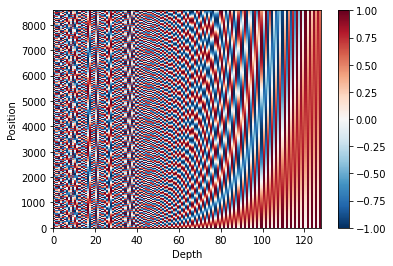

In [368]:
sample_pos_encoding = PositionalEncoding(VOCAB_SIZE, EMBED_DIM)

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap='RdBu_r')
plt.xlabel('Depth')
plt.xlim((0, EMBED_DIM))
plt.ylabel('Position')
plt.colorbar()
plt.show()

In [369]:
# def positional_encoding(length, depth):
#   depth = depth/2

#   positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
#   depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)

#   angle_rates = 1 / (10000**depths)         # (1, depth)
#   angle_rads = positions * angle_rates      # (pos, depth)

#   pos_encoding = np.concatenate(
#       [np.sin(angle_rads), np.cos(angle_rads)],
#       axis=-1) 

#   return tf.cast(pos_encoding, dtype=tf.float32)

In [370]:
# pos_encoding = positional_encoding(VOCAB_SIZE, EMBED_DIM)

# # Check the shape.
# print(pos_encoding.shape)

# # Plot the dimensions.
# plt.pcolormesh(pos_encoding.numpy().T, cmap='RdBu_r')
# plt.ylabel('Depth')
# plt.xlabel('Position')
# plt.colorbar()
# plt.show()

In [371]:
# class PositionalEncoding(tf.keras.layers.Layer):
#   def __init__(self, vocab_size, d_model):
#     super().__init__()
#     self.d_model = d_model
#     self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True) 
#     self.pos_encoding = positional_encoding(length=vocab_size, depth=d_model)

#   def compute_mask(self, *args, **kwargs):
#     return self.embedding.compute_mask(*args, **kwargs)

#   def call(self, x):
#     length = tf.shape(x)[1]
#     x = self.embedding(x)
#     # This factor sets the relative scale of the embedding and positonal_encoding.
#     x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
#     x = x + self.pos_encoding[tf.newaxis, :length, :]
#     return x

In [372]:
def scaled_dot_product_attention(query, key, value, mask):
  # query 크기 : (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
  # key 크기 : (batch_size, num_heads, key의 문장 길이, d_model/num_heads)
  # value 크기 : (batch_size, num_heads, value의 문장 길이, d_model/num_heads)
  # padding_mask : (batch_size, 1, 1, key의 문장 길이)

  # Q와 K의 곱. 어텐션 스코어 행렬.
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # 스케일링
  # dk의 루트값으로 나눠준다.
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # 마스킹. 어텐션 스코어 행렬의 마스킹 할 위치에 매우 작은 음수값을 넣는다.
  # 매우 작은 값이므로 소프트맥스 함수를 지나면 행렬의 해당 위치의 값은 0이 된다.
  if mask is not None:
    logits += (mask * -1e9)

  # 소프트맥스 함수는 마지막 차원인 key의 문장 길이 방향으로 수행된다.
  # attention weight : (batch_size, num_heads, query의 문장 길이, key의 문장 길이)
  attention_weights = tf.nn.softmax(logits, axis=-1)

  # output : (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
  output = tf.matmul(attention_weights, value)

  return output, attention_weights

In [373]:
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    # d_model을 num_heads로 나눈 값.
    # 논문 기준 : 64
    self.depth = d_model // self.num_heads

    # WQ, WK, WV에 해당하는 밀집층 정의
    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    # WO에 해당하는 밀집층 정의
    self.dense = tf.keras.layers.Dense(units=d_model)

  # num_heads 개수만큼 q, k, v를 split하는 함수
  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # 1. WQ, WK, WV에 해당하는 밀집층 지나기
    # q : (batch_size, query의 문장 길이, d_model)
    # k : (batch_size, key의 문장 길이, d_model)
    # v : (batch_size, value의 문장 길이, d_model)
    # 참고) 인코더(k, v)-디코더(q) 어텐션에서는 query 길이와 key, value의 길이는 다를 수 있다.
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # 2. 헤드 나누기
    # q : (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
    # k : (batch_size, num_heads, key의 문장 길이, d_model/num_heads)
    # v : (batch_size, num_heads, value의 문장 길이, d_model/num_heads)
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # 3. 스케일드 닷 프로덕트 어텐션. 앞서 구현한 함수 사용.
    # (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
    scaled_attention, _ = scaled_dot_product_attention(query, key, value, mask)
    # (batch_size, query의 문장 길이, num_heads, d_model/num_heads)
    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # 4. 헤드 연결(concatenate)하기
    # (batch_size, query의 문장 길이, d_model)
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # 5. WO에 해당하는 밀집층 지나기
    # (batch_size, query의 문장 길이, d_model)
    outputs = self.dense(concat_attention)

    return outputs

In [374]:
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, key의 문장 길이)
  return mask[:, tf.newaxis, tf.newaxis, :]

In [375]:
def encoder_layer(dff, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

  # 인코더는 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 멀티-헤드 어텐션 (첫번째 서브층 / 셀프 어텐션)
  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs, 'key': inputs, 'value': inputs, # Q = K = V
          'mask': padding_mask # 패딩 마스크 사용
      })

  # 드롭아웃 + 잔차 연결과 층 정규화
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  # 포지션 와이즈 피드 포워드 신경망 (두번째 서브층)
  outputs = tf.keras.layers.Dense(units=dff, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 드롭아웃 + 잔차 연결과 층 정규화
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [376]:
def encoder(vocab_size, num_layers, dff,
            d_model, num_heads, dropout,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 인코더는 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 포지셔널 인코딩 + 드롭아웃
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # 인코더를 num_layers개 쌓기
  for i in range(num_layers):
    outputs = encoder_layer(dff=dff, d_model=d_model, num_heads=num_heads,
        dropout=dropout, name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [377]:
# 디코더의 첫번째 서브층(sublayer)에서 미래 토큰을 Mask하는 함수
def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x) # 패딩 마스크도 포함
  return tf.maximum(look_ahead_mask, padding_mask)

In [378]:
def decoder_layer(dff, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")

  # 디코더는 룩어헤드 마스크(첫번째 서브층)와 패딩 마스크(두번째 서브층) 둘 다 사용.
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 멀티-헤드 어텐션 (첫번째 서브층 / 마스크드 셀프 어텐션)
  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs, 'key': inputs, 'value': inputs, # Q = K = V
          'mask': look_ahead_mask # 룩어헤드 마스크
      })

  # 잔차 연결과 층 정규화
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

  # 멀티-헤드 어텐션 (두번째 서브층 / 디코더-인코더 어텐션)
  attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1, 'key': enc_outputs, 'value': enc_outputs, # Q != K = V
          'mask': padding_mask # 패딩 마스크
      })

  # 드롭아웃 + 잔차 연결과 층 정규화
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

  # 포지션 와이즈 피드 포워드 신경망 (세번째 서브층)
  outputs = tf.keras.layers.Dense(units=dff, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 드롭아웃 + 잔차 연결과 층 정규화
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

In [379]:
def decoder(vocab_size, num_layers, dff,
            d_model, num_heads, dropout,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')

  # 디코더는 룩어헤드 마스크(첫번째 서브층)와 패딩 마스크(두번째 서브층) 둘 다 사용.
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 포지셔널 인코딩 + 드롭아웃
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # 디코더를 num_layers개 쌓기
  for i in range(num_layers):
    outputs = decoder_layer(dff=dff, d_model=d_model, num_heads=num_heads,
        dropout=dropout, name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

In [380]:
def transformer(vocab_size, num_layers, dff,
                d_model, num_heads, dropout,
                name="transformer"):

    # Encoder Layer
    # 인코더의 입력
    enc_inputs = tf.keras.Input(shape=(None,), name="encoder_inputs")

    # 인코더의 패딩 마스크
    enc_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None),
        name='enc_padding_mask')(enc_inputs)

    # 인코더의 출력은 enc_outputs. 디코더로 전달된다.
    enc_outputs = encoder(vocab_size=vocab_size, num_layers=num_layers, dff=dff,
        d_model=d_model, num_heads=num_heads, dropout=dropout,
        )(inputs=[enc_inputs, enc_padding_mask]) # 인코더의 입력은 입력 문장과 패딩 마스크

    # Decoder Layer
    # 디코더의 입력
    dec_inputs = tf.keras.Input(shape=(None,), name="decoder_inputs")

    # 디코더의 룩어헤드 마스크(첫번째 서브층)
    look_ahead_mask = tf.keras.layers.Lambda(
        create_look_ahead_mask, output_shape=(1, None, None),
        name='look_ahead_mask')(dec_inputs)

    # 디코더의 패딩 마스크(두번째 서브층)
    dec_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None),
        name='dec_padding_mask')(enc_inputs)

    # 디코더의 출력은 dec_outputs. 출력층으로 전달된다.
    dec_outputs = decoder(vocab_size=vocab_size, num_layers=num_layers, dff=dff,
        d_model=d_model, num_heads=num_heads, dropout=dropout,
        )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

    # 다음 단어 예측을 위한 출력층
    outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

    return tf.keras.Model(inputs=[enc_inputs, dec_inputs], outputs=outputs, name="fransformer_model")

In [381]:
# small_transformer = transformer(
#     vocab_size = 9000,
#     num_layers = 6,
#     dff = 512,
#     d_model = 128,
#     num_heads = 4,
#     dropout = 0.3,
#     name="small_transformer")

# tf.keras.utils.plot_model(small_transformer,show_shapes=True)

In [382]:
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))

  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)

In [383]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()
    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)
    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, dtype=tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Text(0.5, 0, 'Train Step')

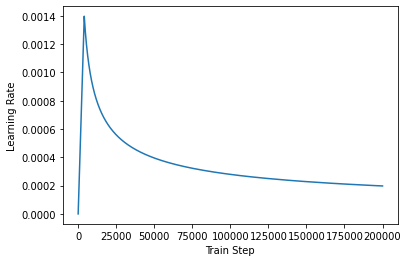

In [384]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [385]:
tf.keras.backend.clear_session()

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    dff=DFF,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

(1, 8568, 256)
(1, 8568, 256)


#### 8. **클래스를 연결하여 모델을 정의한 후 학습합니다.**

In [386]:
MAX_LENGTH = 20

learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  # ensure labels have shape (batch_size, MAX_LENGTH - 1)
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [387]:
%%time
EPOCHS = 3
model_history = model.fit(train_dataset
                          , epochs=EPOCHS
                          , validation_data=val_dataset
                          )

Epoch 1/3
55/55 [==============================] - 135s 2s/step - loss: 4.7922 - accuracy: 0.0204 - val_loss: 4.6282 - val_accuracy: 0.0526
Epoch 2/3
55/55 [==============================] - 101s 2s/step - loss: 4.5885 - accuracy: 0.0526 - val_loss: 4.4480 - val_accuracy: 0.0526
Epoch 3/3
55/55 [==============================] - 99s 2s/step - loss: 4.4140 - accuracy: 0.0526 - val_loss: 4.2834 - val_accuracy: 0.0526
CPU times: user 7min 30s, sys: 15.7 s, total: 7min 46s
Wall time: 6min 18s


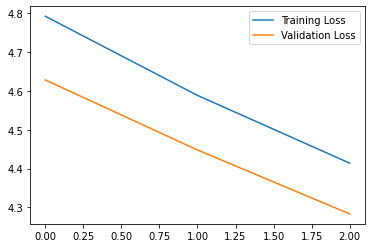

In [388]:
plt.plot(model_history.history["loss"], label="Training Loss")
plt.plot(model_history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

In [389]:
def evaluate(sentence):
  sentence = preprocess_sentence(sentence)

  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  output = tf.expand_dims(START_TOKEN, 0)

  # 디코더의 예측 시작
  for i in range(MAX_LENGTH):
    predictions = model(inputs=[sentence, output], training=False)

    # 현재(마지막) 시점의 예측 단어를 받아온다.
    predictions = predictions[:, -1:, :]
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # 만약 마지막 시점의 예측 단어가 종료 토큰이라면 예측을 중단
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # 마지막 시점의 예측 단어를 출력에 연결한다.
    # 이는 for문을 통해서 디코더의 입력으로 사용될 예정이다.
    output = tf.concat([output, predicted_id], axis=-1)

  return tf.squeeze(output, axis=0)


def predict(sentence):
  prediction = evaluate(sentence)

  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  print('Input: {}'.format(sentence))
  print('Output: {}'.format(predicted_sentence))

  return predicted_sentence

In [390]:
def preprocess_sentence(sentence):
  sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
  sentence = sentence.strip()
  return sentence

In [391]:
%%time
output = predict('오늘 날씨 어때?')

Input: 오늘 날씨 어때?
Output: 
CPU times: user 222 ms, sys: 5.05 ms, total: 227 ms
Wall time: 226 ms


In [392]:
%%time
output = predict('위로봇이 멍청해서 속상해')

Input: 위로봇이 멍청해서 속상해
Output: 
CPU times: user 199 ms, sys: 3.08 ms, total: 202 ms
Wall time: 201 ms
